## Imagenes 

In [15]:
import numpy as np
import torch
import torchvision
torch.set_printoptions(edgeitems=2, threshold=50)

<img src="./img/rgb.png" />

imageio transfomra la imagen en una matriz de numpy **Altura x Largo x Channel** <br>
documentacion : https://imageio.readthedocs.io/en/stable/sec_gettingstarted.html

In [3]:
import imageio

img_arr = imageio.imread('./img/gato.jpg')
img_arr.shape #numpy, H:W:C

(360, 640, 3)

In [4]:
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1) #Cambiamos el orden de las axis
out.shape

torch.Size([3, 360, 640])

<h5> Full pipeline:</h5> <br>
    1- Inicializar Tensor para imagenes 3x3x256x256 (batch)<br>
    Loop:<br>
    2- Leer imagen en numpy matriz<br>
    3- Permuteo de las dimensiones<br>
    4- Transformación a 256x256<br>
    5- Agrego al batch<br>

In [28]:
from torchvision import transforms
trs = transforms.Compose([transforms.Resize((256,256))])

In [40]:
import os
data_dir = "./img/"
filenames = ["perro.jpg", "gato.jpg", "caballo.jpg"]
batch = torch.zeros(len(filenames),3,256,256)

for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t =  trs(img_t)
    batch[i] = img_t

In [41]:
batch.shape

torch.Size([3, 3, 256, 256])

Es muy común para los modelos de redes neuronales normalizar los datos.<br>
Caculamos la media y desvío por Channel:

In [73]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

In [75]:
batch[:,c].mean()

tensor(1.1921e-07)

In [76]:
batch[:,c].std()

tensor(1.)

## Data Volumétrica 
---
Es común por ejemplo en imagenes médica tener datos volumétricos, por ejemplo en los CT (computer tomography). 
Los CT sólo utilizan escalas de grises, por ende en este caso la tercera dimensión es la altura.

<img src="img/cerebro.png"/>

In [44]:
dir_path = "extras/data/volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 99/99  (100.0%)


(99, 512, 512)

In [45]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)

vol.shape

torch.Size([1, 99, 512, 512])

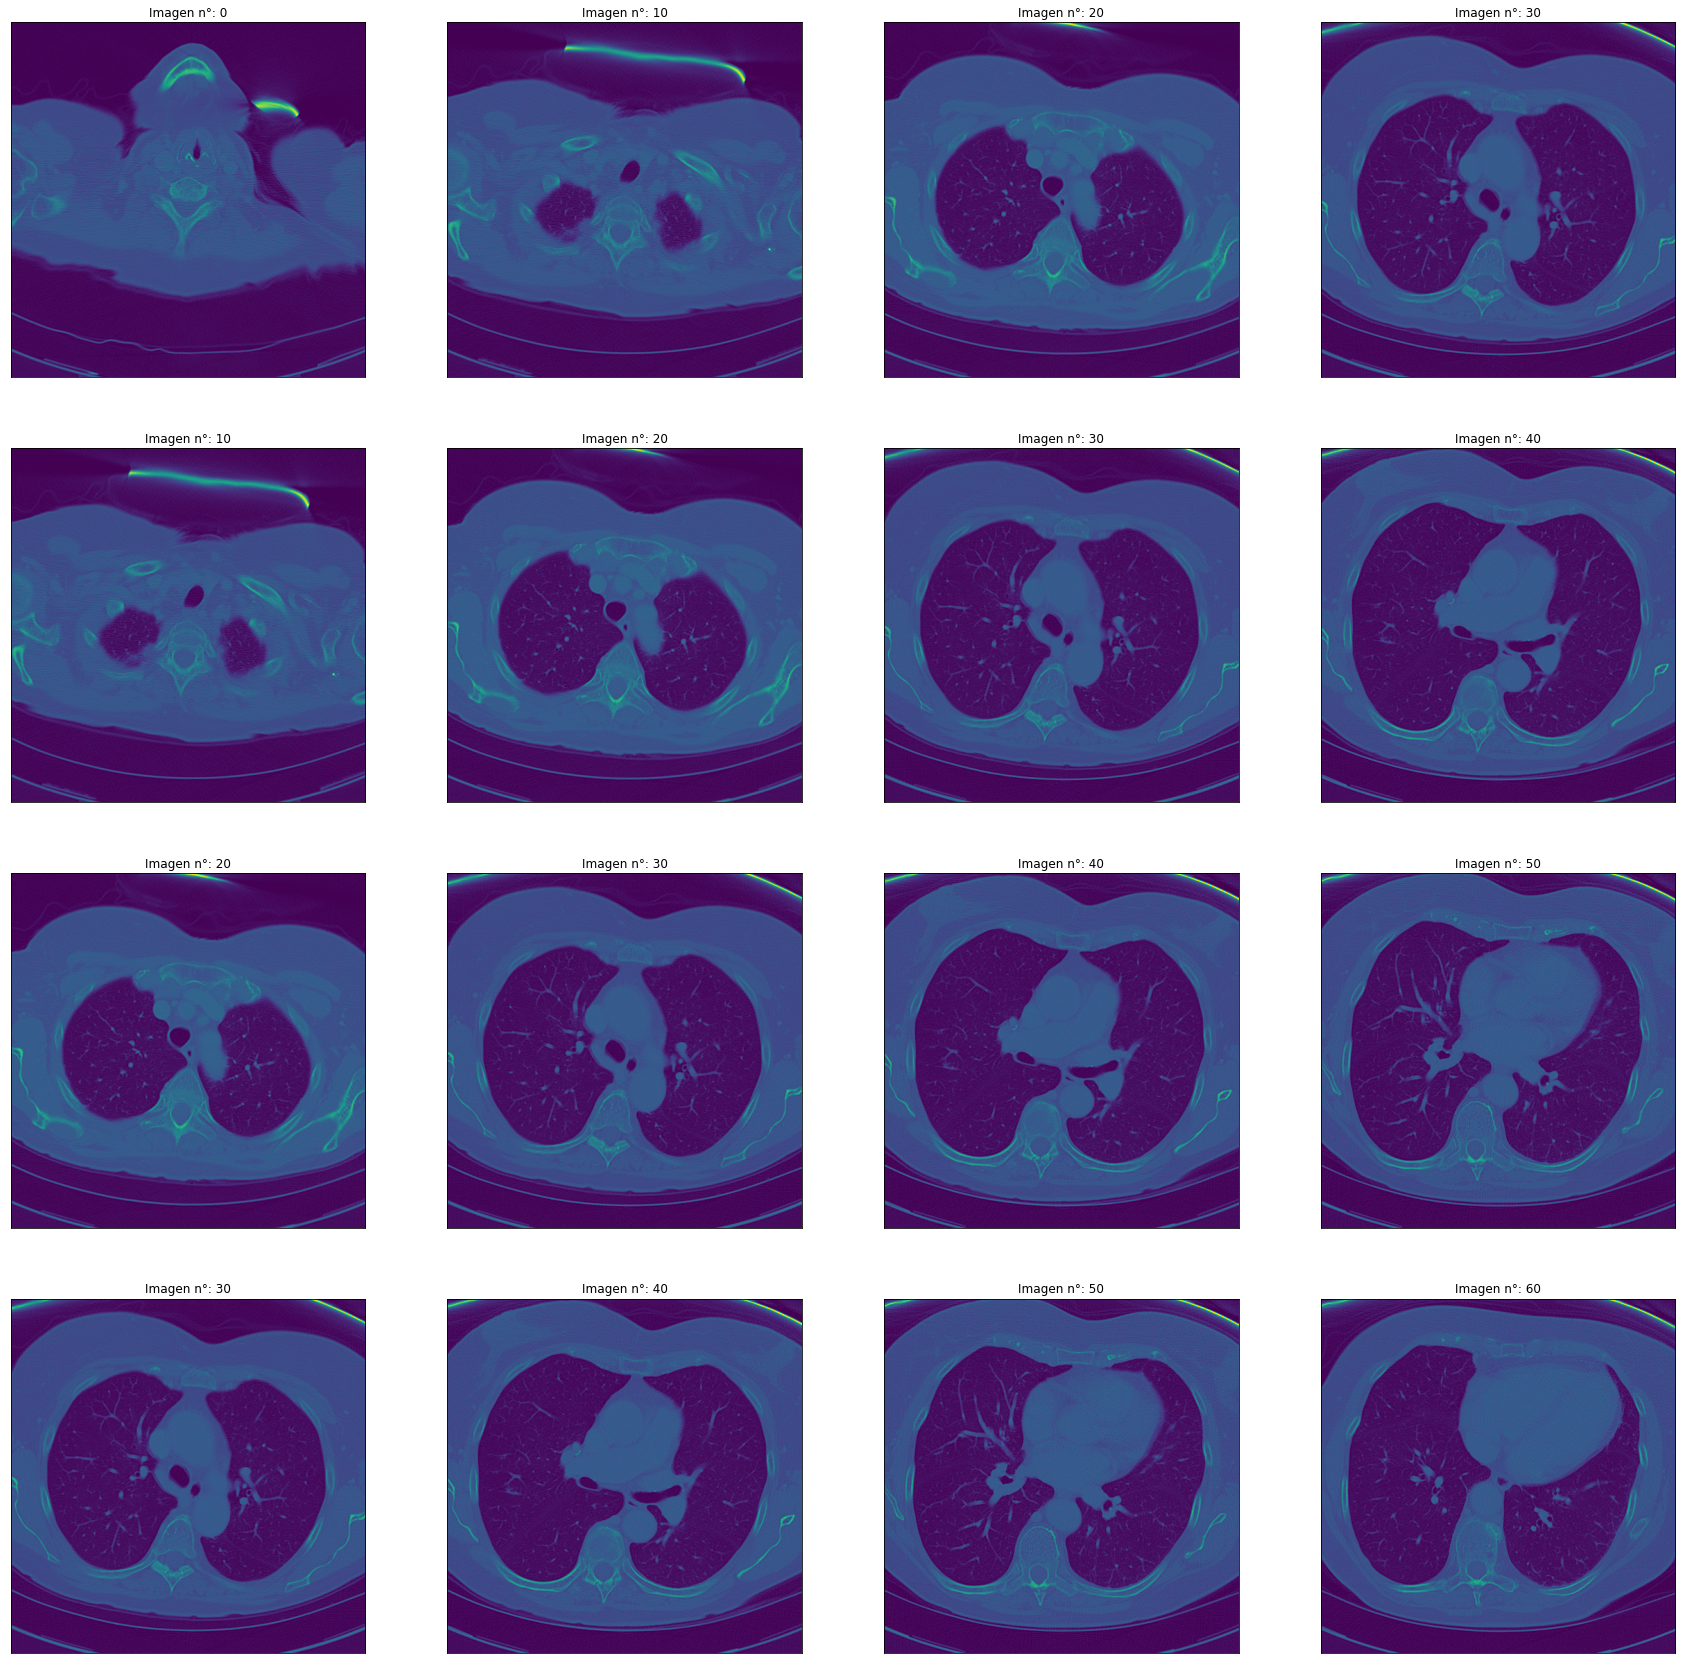

In [92]:
import matplotlib.pyplot as plt


_ , ax = plt.subplots(4,4, figsize=(30,30))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(vol_arr[i*10+j*10])
        ax[i][j].set_xticks([], minor=False)
        ax[i][j].set_yticks([], minor=False)
        ax[i][j].set_title(f"Imagen n°: {i*10+j*10}")

## Datos Tabulares 
---
Es el formato más común, al estilo tabla de excel. 

<img src="img/wine.png"/>

In [96]:
import csv
wine_path = "extras/data/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, 
                         delimiter=";",skiprows=1)
wineq_numpy.shape

(4898, 12)

In [97]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [101]:
#Datos
data = wineq[:, :-1] # <1>
data, data.shape

#Target, predecir
target = wineq[:, -1].long() #enteros
target

tensor([6, 6,  ..., 7, 6])

Con variables categoricas generalmente usamos one hot encoding

<img src="./img/categorical.png"/>

In [106]:
target.unsqueeze(1), target.unsqueeze(1).shape


(tensor([[6],
         [6],
         ...,
         [7],
         [6]]),
 torch.Size([4898, 1]))

In [107]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot


tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])

el guión abajo indica "inplace operation"

In [108]:
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])

tambíen normalizamos los datos

In [113]:
data.shape

torch.Size([4898, 11])

In [114]:
data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)
data_mean.shape

torch.Size([11])

In [115]:
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  ..., -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  ...,  1.3422e-03, -8.2419e-01],
        ...,
        [-1.6054e+00,  1.1666e-01,  ..., -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  ..., -1.4882e+00,  1.0448e+00]])

## Serie de Tiempo
---

<img src="img/ts.png"/>

In [117]:
bikes_numpy = np.loadtxt(
    "extras/data/bike-sharing-dataset/hour-fixed.csv", 
    dtype=np.float32, 
    delimiter=",", 
    skiprows=1, 
    converters={1: lambda x: float(x[8:10])}) 

bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00,  ..., 1.3000e+01, 1.6000e+01],
        [2.0000e+00, 1.0000e+00,  ..., 3.2000e+01, 4.0000e+01],
        ...,
        [1.7378e+04, 3.1000e+01,  ..., 4.8000e+01, 6.1000e+01],
        [1.7379e+04, 3.1000e+01,  ..., 3.7000e+01, 4.9000e+01]])

cada fila representa una hora

In [118]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

In [120]:
#Transformación en matrices de 24 horas
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

El objetivo est tener NxCxL:
- N: cantidad de muestras
- C: Channel, categoría
- L : Tamaño de la sequencia (24hrs)

#### Variables categoricas
La variable 9 indica tipo de clima, 4 categorías.
Aplico one hot.

In [121]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

In [122]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4,
                                   daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [126]:
daily_weather_onehot.scatter_(
    1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [137]:
#Concadenamos con los anteriores
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

Otra opción es tomarla como ordinal,  y normalizar los datos entre 0 y 1.

In [128]:
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - temp_min)
                         / (temp_max - temp_min))

Tambíen está la opción de normalizar con la media y el desvío. 

In [129]:
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp))
                         / torch.std(temp))

## Texto 

In [138]:
with open('extras/data/jane-austen/1342-0.txt', encoding='utf8') as f:
    text = f.read()

In [139]:
lines = text.split('\n')
line = lines[200]
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

####  One hot encoding

In [140]:
letter_t = torch.zeros(len(line), 128) # <1> 
letter_t.shape

torch.Size([70, 128])

In [144]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0  # asumimos ASCII
    letter_t[i][letter_index] = 1

In [145]:
letter_t

tensor([[1., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])

Ahora con todo el texto

In [148]:
def clean_words(input_str):
    #Ignora simbolos innecesarios, y hace split de todo el texto
    punctuation = '.,;:"!?”“_-'
    word_list = input_str.lower().replace('\n',' ').split()
    word_list = [word.strip(punctuation) for word in word_list]
    return word_list

words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

se arma un diccionario con cada palabra en el texto.

In [149]:
word_list = sorted(set(clean_words(text)))
word2index_dict = {word: i for (i, word) in enumerate(word_list)}

len(word2index_dict), word2index_dict['impossible']

(7261, 3394)

usamos este diccionario para armar un one hot de la linea anterior

In [150]:
word_t = torch.zeros(len(words_in_line), len(word2index_dict))

for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i][word_index] = 1
    print('{:2} {:4} {}'.format(i, word_index, word))
    
print(word_t.shape)


 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him
torch.Size([11, 7261])


En la práctica se suele usar una técnica llamada word embeddings.

<img src="img/embedings.png"/>

In [151]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [163]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 2)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[0.7271, 0.5616]], grad_fn=<EmbeddingBackward>)
